<a href="https://colab.research.google.com/github/molan/quantitative_estimation/blob/main/Value_graph_vINCI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case 1: Computation on value graph for vINCI

1. Martin Molan
1. Gregor Molan

+ 2021-05-16 .. Initial code
+ 2021-06-30 .. layer -> subgraph
+ 2021-07-03 .. vINCI
+ 2022-07-20 .. new build with new Keras, Tensorflow (need nightly build), Keract, Matplotlib
```
conda install keras
conda install tensorflow
pip install keract
pip install matplotlib
pip install tf-nightly
jupyter notebook Value_graph_vINCI.1.ipynb
```
+ 2022-07-21
    * Sort functionality risk estimation by 90 % of trade-off function : `loss_percentage_array`
    * Correctly plot results - use 5 backend items and final value: `for i in range(0,6):`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prerequisites-(imports)" data-toc-modified-id="Prerequisites-(imports)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prerequisites (imports)</a></span></li><li><span><a href="#Value-graph-definition" data-toc-modified-id="Value-graph-definition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Value graph definition</a></span><ul class="toc-item"><li><span><a href="#Definition-of-model-topology" data-toc-modified-id="Definition-of-model-topology-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Definition of model topology</a></span></li><li><span><a href="#Definition-of-input-parameters-(graph-edge-weights)" data-toc-modified-id="Definition-of-input-parameters-(graph-edge-weights)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Definition of input parameters (graph edge weights)</a></span></li><li><span><a href="#Definition-of-input-variables" data-toc-modified-id="Definition-of-input-variables-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Definition of input variables</a></span></li><li><span><a href="#Custom-activation-function" data-toc-modified-id="Custom-activation-function-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Custom activation function</a></span></li><li><span><a href="#Definition-of-learning-rate" data-toc-modified-id="Definition-of-learning-rate-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Definition of learning rate</a></span></li><li><span><a href="#Setup-the-model" data-toc-modified-id="Setup-the-model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Setup the model</a></span></li></ul></li><li><span><a href="#Computing-value-graph" data-toc-modified-id="Computing-value-graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Computing value graph</a></span><ul class="toc-item"><li><span><a href="#Compute-gradients" data-toc-modified-id="Compute-gradients-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compute gradients</a></span></li><li><span><a href="#Print-model-information" data-toc-modified-id="Print-model-information-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Print model information</a></span></li><li><span><a href="#Functionality-risk-estimation" data-toc-modified-id="Functionality-risk-estimation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Functionality risk estimation</a></span></li></ul></li><li><span><a href="#Presenting-results" data-toc-modified-id="Presenting-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Presenting results</a></span><ul class="toc-item"><li><span><a href="#Plot-loss-values-according-to-skipped-items-from-Backend-functionality-layer" data-toc-modified-id="Plot-loss-values-according-to-skipped-items-from-Backend-functionality-layer-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plot loss values according to skipped items from Backend functionality layer</a></span></li><li><span><a href="#Legend-is-placed-outside-a-plot" data-toc-modified-id="Legend-is-placed-outside-a-plot-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Legend is placed outside a plot</a></span></li></ul></li><li><span><a href="#Additional/Optional-information" data-toc-modified-id="Additional/Optional-information-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Additional/Optional information</a></span><ul class="toc-item"><li><span><a href="#About-activation-function" data-toc-modified-id="About-activation-function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>About activation function</a></span></li></ul></li></ul></div>

## Prerequisites (imports)


### Install missing libraries

In [1]:
!pip install keract > /dev/null
!pip install matplotlib > /dev/null
!pip install tf-nightly > /dev/null

### Import libraries

In [2]:
import keras;
#   from keras.layers import Activation, Concatenate, Dense, Input, Layer
#   from keras.models import Model
#   from keras.utils.vis_utils import plot_model;

import keract; 
#   from keract import get_activations;
#   from keract import get_gradients_of_activations;

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt;
import matplotlib.gridspec as gridspec;

## Value graph definition

### Definition of model topology

In [3]:
#
# Class for merging Requirement and Backend functionality layers
#
class RequBack(keras.layers.Layer):
    def __init__(self, units=32, input_dim1=32,
               input_dim2=32):
        super(RequBack, self).__init__()

        # Var. for weights for requirement signal
        # is defined as "trainable variable".
        # Generate initialized tensors.
        w_init1 = tf.ones_initializer()
        self.requirements_variable = tf.Variable(
            initial_value = w_init1(
                shape=(input_dim1, units),
                dtype="float32"),
            trainable=True
        )

        # Variable for weights for backend signal
        # is defined as "trainable variable"
        w_init2 = tf.random_normal_initializer()
        self.backend_variable = tf.Variable(
            initial_value = w_init2(
                shape=(input_dim2, units),
                dtype="float32"),
            trainable=True
        )

        # Bias need to be defined if use it or not
        bias_init = tf.random_normal_initializer()
        self.my_dummy_bias = tf.Variable(
            initial_value = bias_init(
                shape=(units,),dtype="float32"),
            trainable=True
        )
    
    def call(self, inputs):
        # Multiplies input vector `input_req`
        # by matrix requirements_variable 
        requirement_matrix = tf.matmul(
            inputs[0],
            self.requirements_variable)

        # Multipliesn input vector `input_backend` 
        # by matrix requirements_variable 
        backend_matrix = tf.matmul(
            inputs[1], self.backend_variable)

        requirement_and_backend = (
            requirement_matrix 
            - requirement_matrix * backend_matrix 
            + self.my_dummy_bias
        )
        return requirement_and_backend

### Definition of input parameters (graph edge weights)

In [4]:
#
# Graph arch values for arcs
# from requirement layer to core functionality layer
#
w_R_0_1 = np.array([
    [0.1, 0.2, 0.2, 0.5],
    [  0, 0.4, 0,   0.6],
    [0.7, 0.3, 0,   0  ],
    [  0, 0.3, 0.3, 0.4]
]);

#
# Graph arch values for arcs
# from backend functionality layer to core functionality layer
#
w_B_0_1 = np.array([
    [ 0.6,  0.4, 0,   0  ],
    [ 0.6,  0.6, 0.8, 0.8],
    [ 0.1,  0.1, 0.9, 0  ],
    [ 0,    0,   0,   0.8],
    [ 1,    1,   1,   1  ]
]);

#
# Bias for Core functionality layer
#
bias_Core = np.array([
    0,
    0,
    0,
    0
]);

#
# Graph arch values for arcs
# from core functionality layer and edge functionality layer
#
w_1_2 = np.array([
    [0.05, 0.00, 0.95],
    [0.3,  0.3,  0.4],
    [0.4,  0.0,  0.6],
    [0.3,  0.0,  0.7]
]);

#
# Bias for Edge functionality layer
#
bias_Edge = np.array([
    0,
    0,
    0
]);

#
# Graph arch values for arc
# from edge functionality layer and value layer
#
w_2_3 = np.array([
    [0.8],
    [0.5],
    [  1]
]);

#
# Bias for Value layer
#
bias_value = np.array([
    0
]);

my_weights = [
   w_R_0_1,
   w_B_0_1,
   bias_Core,
   w_1_2,
   bias_Edge,
   w_2_3,
   bias_value
]

### Definition of input variables

In [5]:
#
# Input variables in vectors for Requirements (r_R) and Bias (r_B)
#
r_R = np.array([[0.4,0.133,0.2,0.267]]);
r_B = np.array([[0,0,0,0,0]]);

### Custom activation function

In [6]:
#
# NOTE: percentage is global variable!
#
def tradeoff(x):
    n = 1 / (1-percentage);
    y = x - x**n/n;
    return(y)

### Definition of learning rate

In [7]:
#
# Definition of learning rate for "Gradient descent (with momentum) optimizer"
#
LR = 0.01;

### Setup the model

In [8]:
#
# Input:
#  percentage
#  my_weights

# input global variable 
#  percentage ... percentage in activation function

# global variables used for setup custom layer names of the model 
relu_activ_f_name = 'relu_activ';   
tradeoff_activ_f_name = 'tradeoff_activ';
output_name = 'output_subgraph';
edge_name  = 'edge_subgraph';

#
# Input parameters
#  my_weights ... graph edge weights, topology of the model
#
# Return
#  Keras Model class
#
def setup_model(my_weights):
    
    # Following variables can have arbitrary values (but distinguish)
    #   for custom layer names of the model
    requ1_name = 'requirement_subgraph_0';
    requ2_name = 'requirement_subgraph_1';
    back1_name = 'backend_subgraph_0';
    back2_name = 'backend_subgraph_1';
    
    # --- Model definition ---
    # Define two sets of input layers
    input_req = keras.layers.Input(shape=(4,),name=requ1_name);
    input_backend = keras.layers.Input(shape=(5,), name = back1_name);

    # Define Core layer
    # Core layer consists of 'requ_back',
    #    (where name is inherited from class RequBack),
    # relu activation function (relu_activ_f_name)
    # and our custom trade-off function (tradeoff_activ_f_name).
    requ_back = RequBack(4, 4, 5)([input_req,input_backend]);
    input_relu = keras.layers.Activation(
                                         'relu',
                                          name=relu_activ_f_name
                                        )(requ_back);
    core = keras.layers.Activation(
                                   tradeoff,
                                   name=tradeoff_activ_f_name
                                  )(input_relu);

    # Define Edge layer
    edge = keras.layers.Dense(3, name = edge_name)(core);
    
    # Define Value layer
    output = keras.layers.Dense(1, name = output_name)(edge)

    # --- Model compile ---
    my_model = keras.models.Model(
        inputs=[input_req, input_backend],
        outputs=output
    )
    my_optimizer = keras.optimizers.SGD(learning_rate=LR)
    my_model.compile(optimizer=my_optimizer, loss='mse');
    
    # --- Set model weights ---
    my_model.set_weights(my_weights);
    
    return(my_model);        

In [9]:
#
# To use keract.get_gradients_of_activations in computing gradients
# we should disable TF eager mode 
#
tf.compat.v1.disable_eager_execution()

In [10]:
#
# Setup the model 'value_graph_model' 
# with given 'percentage' for activation function
#
percentage = 0.8;
value_graph_model = setup_model(my_weights);

## Computing value graph

### Compute gradients

In [11]:
#
# Compute dictionary of gradients: d_grad
#

#
# Prerequisites:
# r_R, r_B ... defined in previous cells
#

# y value for keract.get_gradients_of_activations
my_y = np.array([[0]]);

# Output d_grad is a dictionary of gradients mapping each layer
# to the values of its gradients (regarding [r_R, r_B] and my_y).
d_grad = keract.get_gradients_of_activations(
        value_graph_model, 
        [r_R, r_B],
        my_y,
        output_format='simple');

In [12]:
d_grad

OrderedDict([('requ_back',
              array([[1.7858292, 1.4185945, 1.6602111, 1.6595005]], dtype=float32)),
             ('relu_activ',
              array([[1.7858292, 1.4185945, 1.6602111, 1.6595005]], dtype=float32)),
             ('tradeoff_activ',
              array([[1.7877059, 1.4265532, 1.6613026, 1.6974176]], dtype=float32)),
             ('edge_subgraph',
              array([[1.4446108 , 0.90288174, 1.8057635 ]], dtype=float32)),
             ('output_subgraph', array([[1.8057635]], dtype=float32))])

In [13]:
print("Edge funtionality gradients:",
      np.round(d_grad[edge_name], 2))

Edge funtionality gradients: [[1.44 0.9  1.81]]


In [14]:
#
# Compute gradients for Core layer: core_grad
#

# get value for key 'requ_back' or any 'requ_back_x' 
#   from the model calculation
d_requ_back_grad = next(vd_value for my_key,vd_value in d_grad.items()
                        if 'requ_back' in my_key);

# calculate gradients for Core layer
core_grad = d_requ_back_grad \
            * d_grad[relu_activ_f_name] \
            * d_grad[tradeoff_activ_f_name];

In [15]:
d_requ_back_grad

array([[1.7858292, 1.4185945, 1.6602111, 1.6595005]], dtype=float32)

In [16]:
print("Core funtionality gradients:",
      np.round(core_grad, 2))

Core funtionality gradients: [[5.7  2.87 4.58 4.67]]


In [17]:
print("Requiremet input gradients:",
      np.round(
          (my_weights[0].dot(core_grad.T)).T,
          2))

Requiremet input gradients: [[4.4  3.95 4.85 4.1 ]]


In [18]:
print("Backend input gradients:",
      np.round(
          (-my_weights[1].dot(my_weights[0].dot(r_R.T)*core_grad.T)).T,
          2))

Backend input gradients: [[-1.07 -3.13 -1.52 -0.77 -4.41]]


### Print model information

In [19]:
#
# Print a string summary about the content of built model
#
value_graph_model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 requirement_subgraph_0 (InputL  [(None, 4)]         0           []                               
 ayer)                                                                                            
                                                                                                  
 backend_subgraph_0 (InputLayer  [(None, 5)]         0           []                               
 )                                                                                                
                                                                                                  
 requ_back (RequBack)           (None, 4)            40          ['requirement_subgraph_0[0][0]', 
                                                                  'backend_subgraph_0[0][0]'] 

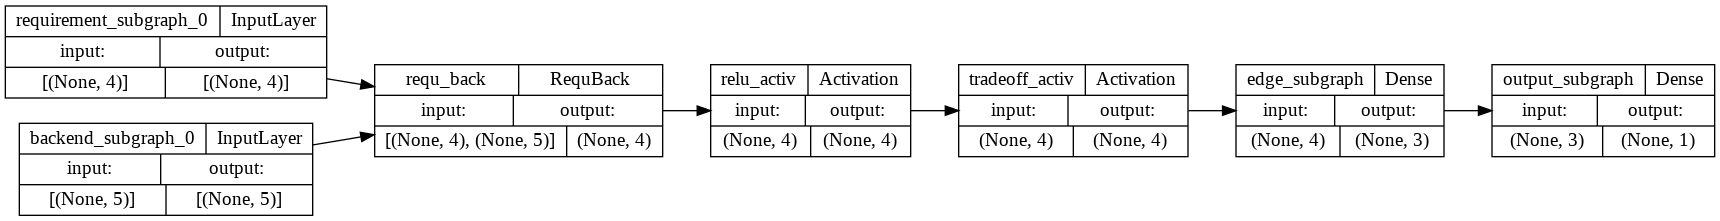

In [20]:
#
# Visulize the built model in 'value_graph_model'
#
keras.utils.plot_model(
    value_graph_model,
    show_shapes=True,
    show_layer_names=True, 
    rankdir = 'LR',
    to_file = 'graph_value.pdf'
)

# print to Jupyter notebokk
keras.utils.plot_model(value_graph_model,
           show_shapes=True, 
           show_layer_names=True,
           rankdir = 'LR'
)

### Functionality risk estimation

In [21]:
#
# Computation of the Functionality risk
#
# Functionality risk is an estimated decrease in software product value,
# if a certain backend functionality is not implemented.
#

requirement_name = [
    'Quality of life',
    'Cardial',
    'Posture',
    'Activity'
];
backend_name = [
    'Without smart shoes', 
    'Without smart watch', 
    'Without smart phone', 
    'Without O2 detector',
    'Without cloud infrastructure'
];

def loss_value(value_graph_model, r, i_array):
    return_loss_value = keract.get_activations(
        value_graph_model,
        [r, np.array([i_array])]
    );
    return(return_loss_value);


#
# Input global variable: percentage
#
def print_final_value_perctentage(loss_percentage_array):
    level_0_names = [requirement_name, backend_name]; 
    # we are eliminating only bavckend functionalities
    level_0_names = [backend_name];
    
    # set up the model 'value_graph_model' 
    value_graph_model = setup_model(my_weights);
    
    # get output_name value without output_name type
    print("{:.2f}".format(loss_value(value_graph_model, 
                                     r_R,
                                     [0]*5)[output_name][0][0] 
                         ),
          ': Final value with all backend functionalities'
         );

    for level_0_functionality in range(0,len(level_0_names)):
        j = int(10 * percentage );
        
        loss_percentage_array[0][j] = round(
            loss_value(value_graph_model,
                       r_R,
                       [0]*5
                      )[output_name][0][0],
            2
        );

        loss_percentage_array[0][0] = 'Implemented ALL';
    
        for i in range(0,len(level_0_names[level_0_functionality])):
            funct_array    = [0]*len(level_0_names[level_0_functionality]);
            funct_array[i] = 1;
            
            # get name of backend functionality
            loss_percentage_array[i+1][0] = level_0_names[
                                                level_0_functionality
                                            ][i];
            
            # get output_name value without output_name type
            loss_percentage_array[i+1][j] = round(
                loss_value(value_graph_model,
                           r_R,
                           funct_array
                          )[output_name][0][0],
                2
            );
            print('  ',
                  # get output_name value without output_name type
                  "{:.2f}".format( 
                      loss_value(value_graph_model,
                                 r_R,
                                 funct_array
                                )[output_name][0][0] 
                  ),
                  ':',
#                  'Without',
                  loss_percentage_array[i+1][0],
                );

In [22]:
#
# Compute and print risk estimations for percentages from 10% to 90%
#

# initialize 'loss_percentage_array'
loss_percentage_array = [[0 for i in range(10)] for j in range(6)];

# Note: percentage is global!
for j in range(0,9):
    percentage = (j+1)/10
    # Write values
    print("\n{:n}% : defined percentage for trade off function".
          format( percentage*100 )
    );
    print("-"*45);
    
    # percentage is parameter defined as GlOBAL variable
    print_final_value_perctentage(loss_percentage_array); 


10% : defined percentage for trade off function
---------------------------------------------
0.20 : Final value with all backend functionalities
   0.17 : Without smart shoes
   0.08 : Without smart watch
   0.16 : Without smart phone
   0.16 : Without O2 detector
   0.00 : Without cloud infrastructure

20% : defined percentage for trade off function
---------------------------------------------
0.38 : Final value with all backend functionalities
   0.31 : Without smart shoes
   0.15 : Without smart watch
   0.31 : Without smart phone
   0.29 : Without O2 detector
   0.00 : Without cloud infrastructure

30% : defined percentage for trade off function
---------------------------------------------
0.54 : Final value with all backend functionalities
   0.44 : Without smart shoes
   0.20 : Without smart watch
   0.44 : Without smart phone
   0.40 : Without O2 detector
   0.00 : Without cloud infrastructure

40% : defined percentage for trade off function
---------------------------------

In [23]:
#
# Summary about functionality risk estimation
#
loss_percentage_array

[['Implemented ALL', 0.2, 0.38, 0.54, 0.67, 0.78, 0.85, 0.89, 0.9, 0.9],
 ['Without smart shoes', 0.17, 0.31, 0.44, 0.54, 0.62, 0.67, 0.7, 0.71, 0.71],
 ['Without smart watch', 0.08, 0.15, 0.2, 0.23, 0.25, 0.26, 0.26, 0.26, 0.26],
 ['Without smart phone', 0.16, 0.31, 0.44, 0.54, 0.63, 0.68, 0.72, 0.73, 0.73],
 ['Without O2 detector', 0.16, 0.29, 0.4, 0.49, 0.55, 0.59, 0.61, 0.61, 0.61],
 ['Without cloud infrastructure', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [24]:
#
# Sort functionality risk estimation by 90 % of trade-off function
#
loss_percentage_array.sort(
    reverse=True,
    key=lambda tradeoff90: tradeoff90[9]
)
loss_percentage_array

[['Implemented ALL', 0.2, 0.38, 0.54, 0.67, 0.78, 0.85, 0.89, 0.9, 0.9],
 ['Without smart phone', 0.16, 0.31, 0.44, 0.54, 0.63, 0.68, 0.72, 0.73, 0.73],
 ['Without smart shoes', 0.17, 0.31, 0.44, 0.54, 0.62, 0.67, 0.7, 0.71, 0.71],
 ['Without O2 detector', 0.16, 0.29, 0.4, 0.49, 0.55, 0.59, 0.61, 0.61, 0.61],
 ['Without smart watch', 0.08, 0.15, 0.2, 0.23, 0.25, 0.26, 0.26, 0.26, 0.26],
 ['Without cloud infrastructure', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

## Presenting results

### Plot loss values according to skipped items from Backend functionality layer

0 Implemented ALL
1 Without smart phone
2 Without smart shoes
3 Without O2 detector
4 Without smart watch
5 Without cloud infrastructure


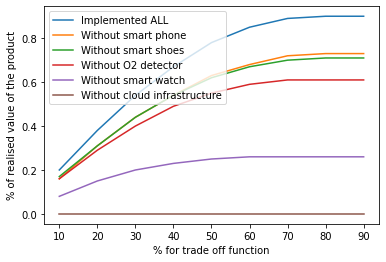

In [25]:
#
# Plot results form 'Rist estimation' computations
#

back_names = [];
for i in range(0,6):
    print(i,loss_percentage_array[i][0]);
    back_names.append(loss_percentage_array[i][0]);
    plt.plot([*range(10,100,10)], loss_percentage_array[i][1:10]);

plt.legend(back_names);
plt.ylabel('% of realised value of the product');
plt.xlabel('% for trade off function');

plt.savefig('value_retained.pdf');

### Legend is placed outside a plot

Implemented ALL
Without smart phone
Without smart shoes
Without O2 detector
Without smart watch
Without cloud infrastructure


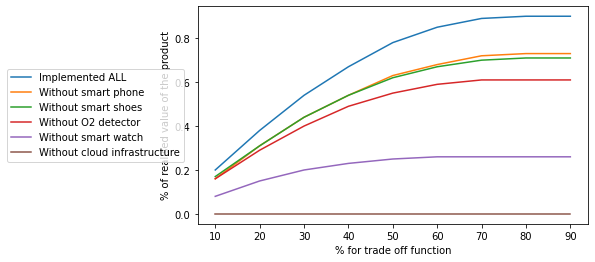

In [26]:
#
# Plot results form 'Risk estimation' computations
#

# define plot size to place legend in the figure during 'savefig'
fig = plt.figure(figsize=(7,4));

back_names = [];
for i in range(0,6):
    print(loss_percentage_array[i][0]);
    back_names.append(loss_percentage_array[i][0]);
    plt.plot([*range(10,100,10)], loss_percentage_array[i][1:10]);

# put legend outside a plot
legend_x = -0.5;
legend_y = 0.5;
plt.ylabel('% of realised value of the product');
plt.xlabel('% for trade off function');
plt.legend(back_names, loc='center left', bbox_to_anchor=(legend_x, legend_y))

# bbox_inches = 'tight' : try to figure out the tight bbox of the figure
plt.savefig('value_retained-left_legend.pdf', bbox_inches = 'tight');

Implemented ALL
Without smart phone
Without smart shoes
Without O2 detector
Without smart watch
Without cloud infrastructure


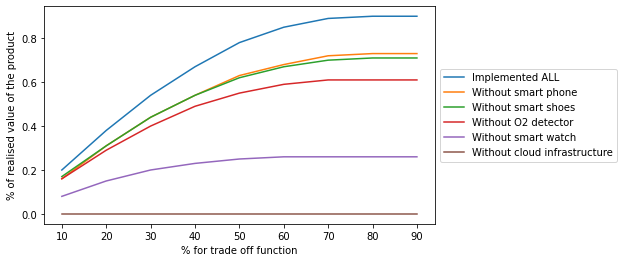

In [27]:
#
# Plot results form 'Risk estimation' computations
#

# define plot size to place legend in the figure during 'savefig'
fig = plt.figure(figsize=(7,4));

back_names = [];
for i in range(0,6):
    print(loss_percentage_array[i][0]);
    back_names.append(loss_percentage_array[i][0]);
    plt.plot([*range(10,100,10)], loss_percentage_array[i][1:10]);

# put legend outside a plot
legend_x = 1;
legend_y = 0.5;
plt.ylabel('% of realised value of the product');
plt.xlabel('% for trade off function');
plt.legend(back_names, loc='center left', bbox_to_anchor=(legend_x, legend_y))

# bbox_inches = 'tight' : try to figure out the tight bbox of the figure
plt.savefig('value_retained-right-legend.pdf', bbox_inches = 'tight');

## Additional/Optional information

### About activation function

Requirements for activation function $y()$ defined as Python function ```tradeoff()```
1. $y(0) = 0  $
1. $y'(0) = 1 $
1. $y(x) \le x, \; x \in [0,1] $
1. $y(1) = percentage $

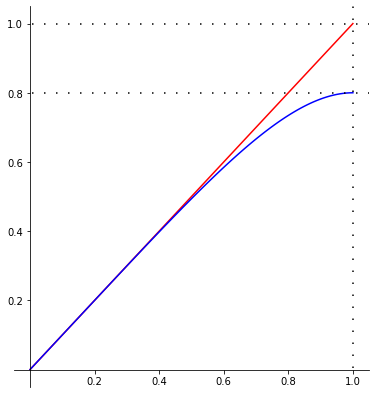

In [28]:
#
# Plot for the 'tradeoff' activation function
#

fig = plt.figure(figsize=(14,7));
gs = gridspec.GridSpec(nrows=1, ncols=2);

# 100 linearly spaced numbers
x = np.linspace(0,1,100);

# setting the axes at the centre

ax1 = fig.add_subplot(gs[0, 1]);
ax1.spines['left'].set_position('zero');
ax1.spines['bottom'].set_position('zero');
ax1.spines['right'].set_color('none');
ax1.spines['top'].set_color('none');
#ax1.xaxis.set_ticks_position('bottom');
#ax1.yaxis.set_ticks_position('left');

# plot the indentiy function red
y0 = x;
plt.plot(x,y0, 'r');
# plot the 80% tradeoff function function blue
percentage = 0.8;
y1 = tradeoff(x);
plt.plot(x,y1, 'b');

plt.xticks(np.arange(0.2, 1.1, step=0.2));  # Set label locations.
plt.yticks(np.arange(0.2, 1.1, step=0.2));  # Set label locations.

plt.axvline(x=1, ymin=0.05, color='k', linestyle=(0, (1, 7)));
plt.axhline(y=1, xmin=0.05, color='k', linestyle=(0, (1, 7)));
plt.axhline(y=0.8, xmin=0.05, color='k', linestyle=(0, (1, 7)));

#plt.tight_layout();
plt.show();